In [1]:
import chainer
import chainer.functions as F
import chainer.links as L
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from lib import utils

In [3]:
class CustomVGG(chainer.Chain):
    def __init__(self):
        super(CustomVGG, self).__init__()
        with self.init_scope():
            self.conv1_1 = L.Convolution2D(3, 64, 3, 1, 1)
            self.conv1_2 = L.Convolution2D(64, 64, 3, 1, 1)
            self.conv2_1 = L.Convolution2D(64, 128, 3, 1, 1)
            self.conv2_2 = L.Convolution2D(128, 128, 3, 1, 1)
            self.conv3_1 = L.Convolution2D(128, 256, 3, 1, 1)
            self.conv3_2 = L.Convolution2D(256, 256, 3, 1, 1)
            self.conv3_3 = L.Convolution2D(256, 256, 3, 1, 1)
            self.conv4_1 = L.Convolution2D(256, 512, 3, 1, 1)
            self.conv4_2 = L.Convolution2D(512, 512, 3, 1, 1)
            self.conv4_3 = L.Convolution2D(512, 512, 3, 1, 1)
            self.conv5_1 = L.Convolution2D(512, 512, 3, 1, 1)
            self.conv5_2 = L.Convolution2D(512, 512, 3, 1, 1)
            self.conv5_3 = L.Convolution2D(512, 512, 3, 1, 1)
            self.fc6 = L.Linear(512 * 7 * 7, 4096)
            self.fc7 = L.Linear(4096, 4096)
            self.fc8 = L.Linear(4096, 1000)

        utils._retrieve(
            'VGG_ILSVRC_16_layers.npz',
            'http://www.robots.ox.ac.uk/%7Evgg/software/very_deep/'
            'caffe/VGG_ILSVRC_16_layers.caffemodel',
            self)

    def __call__(self, x, layers=['prob']):
        h = chainer.Variable(x)

        self.l11 = F.relu(self.conv1_1(h))
        self.l12 = F.relu(self.conv1_2(self.l11))
        self.lp1 = F.max_pooling_2d(self.l12, 2)
        self.l21 = F.relu(self.conv2_1(self.lp1))
        self.l22 = F.relu(self.conv2_2(self.l21))
        self.lp2 = F.max_pooling_2d(self.l22, 2)
        self.l31 = F.relu(self.conv3_1(self.lp2))
        self.l32 = F.relu(self.conv3_2(self.l31))
        self.l33 = F.relu(self.conv3_3(self.l32))
        self.lp3 = F.max_pooling_2d(self.l33, 2)
        self.l41 = F.relu(self.conv4_1(self.lp3))
        self.l42 = F.relu(self.conv4_2(self.l41))
        self.l43 = F.relu(self.conv4_3(self.l42))
        self.lp4 = F.max_pooling_2d(self.l43, 2)
        self.l51 = F.relu(self.conv5_1(self.lp4))
        self.l52 = F.relu(self.conv5_2(self.l51))
        self.l53 = F.relu(self.conv5_3(self.l52))
        self.lp5 = F.max_pooling_2d(self.l53, 2)
        self.lf6 = F.dropout(F.relu(self.fc6(self.lp5)))
        self.lf7 = F.dropout(F.relu(self.fc7(self.lf6)))
        self.lf8 = self.fc8(self.lf7)
        self.prob = F.softmax(self.lf8)

        return self.prob

def _max_pooling_2d(x):
    return F.max_pooling_2d(x, ksize=2)

In [4]:
def backprop(model, img, layer, label=None):
    with chainer.using_config('train', False):
        pred = model(model.xp.asarray(img))
        
    pred.grad = model.xp.zeros_like(pred.data)
    if label == None:
        pred.grad[:, pred.data.argmax()] = 1
    else:
        pred.grad[:, label] = 1
        
    model.cleargrads()
    pred.backward(retain_grad=True)
    
    weights = model.xp.mean(model.__dict__[layer].grad, axis=(2, 3))
    cam = model.xp.tensordot(weights[0], model.__dict__[layer].data[0], axes=(0, 0))
    cam = model.xp.maximum(cam, 0)
    
    return chainer.cuda.to_cpu(cam) # np.ndarray を返す

In [5]:
def post_process(gcam, src):
    gcam = np.uint8(gcam * 255 / gcam.max())
    gcam = cv2.resize(gcam, (224, 224))

    heatmap = cv2.applyColorMap(gcam, cv2.COLORMAP_JET)
    gcam = np.float32(src) + np.float32(heatmap)
    gcam = 255 * gcam / gcam.max()
    #print(gcam.max(), gcam.min())
    out = cv2.cvtColor(gcam, cv2.COLOR_BGR2RGB)
    
    return out

In [6]:
print("init vgg")
model_test = CustomVGG()

print("read image")
src = cv2.imread("./images/dog_cat.png")
src = cv2.resize(src, (224, 224))
x = src.astype(np.float32) - np.float32([103.939, 116.779, 123.68])
x = x.transpose(2, 0, 1)[np.newaxis, :, :, :]

print("calc backprop")
gcam_test = backprop(model_test, x, 'l53', 242)

out_test = post_process(gcam_test, src)

init vgg
read image
calc backprop


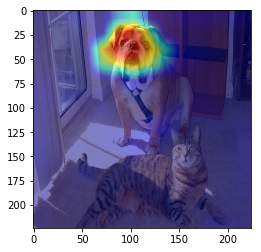

In [7]:
plt.imshow(out_test.astype(np.uint8))
plt.show()